In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

from tqdm import tqdm

from jorbit.integrators.ias15 import IAS15Helper, initialize_ias15_helper, initialize_ias15_integrator_state
from jorbit.utils.states import SystemState
from jorbit.accelerations import newtonian_gravity
from jorbit.data.constants import IAS15_BEZIER_COEFFS

from jorbit.integrators.ias15_clean import _step, _predict_next_step

In [2]:
# ruff: noqa
tracer_positions = jax.random.normal(jax.random.PRNGKey(0), (5, 3))*10
tracer_velocities = jax.random.normal(jax.random.PRNGKey(1), (5, 3))*10
massive_positions = jax.random.normal(jax.random.PRNGKey(2), (10, 3))*10
massive_velocities = jax.random.normal(jax.random.PRNGKey(3), (10, 3))*10
log_gms = jax.random.normal(jax.random.PRNGKey(4), (10,))


state = SystemState(
    tracer_positions=tracer_positions,
    tracer_velocities=tracer_velocities,
    massive_positions=massive_positions,
    massive_velocities=massive_velocities,
    log_gms=log_gms,
    acceleration_func_kwargs={},
    time=0.0,
)
a0 = newtonian_gravity(state)

integrator_state = initialize_ias15_integrator_state(a0)
integrator_state.b = jnp.stack(
    [
        integrator_state.b.p0,
        integrator_state.b.p1,
        integrator_state.b.p2,
        integrator_state.b.p3,
        integrator_state.b.p4,
        integrator_state.b.p5,
        integrator_state.b.p6,
    ]
)
integrator_state.e = jnp.stack(
    [
        integrator_state.e.p0,
        integrator_state.e.p1,
        integrator_state.e.p2,
        integrator_state.e.p3,
        integrator_state.e.p4,
        integrator_state.e.p5,
        integrator_state.e.p6,
    ]
)
integrator_state.dt = 1e-3

In [3]:
ratios, pred_es, pred_bs, actual_bs = [], [], [], []

for i in tqdm(range(1000)):
    start_dt = integrator_state.dt
    state, integrator_state =_step(
        state,
        jax.tree_util.Partial(newtonian_gravity),
        integrator_state
    )
    next_dt = integrator_state.dt
    ratio = next_dt / start_dt
    ratios.append(ratio)
    actual_bs.append(integrator_state.b)
    pred_es.append(integrator_state.er)
    pred_bs.append(integrator_state.br)


ratios = jnp.array(ratios)
step_end_es = jnp.array(pred_es)
step_end_bs = jnp.array(pred_bs)
bs = jnp.array(actual_bs)

100%|██████████| 1000/1000 [00:01<00:00, 679.76it/s]


In [4]:
b_preds = []
for i in range(999):
    _, b_pred = _predict_next_step(ratios[i], pred_es[i], pred_bs[i])
    b_preds.append(b_pred)
b_preds = jnp.array(b_preds)

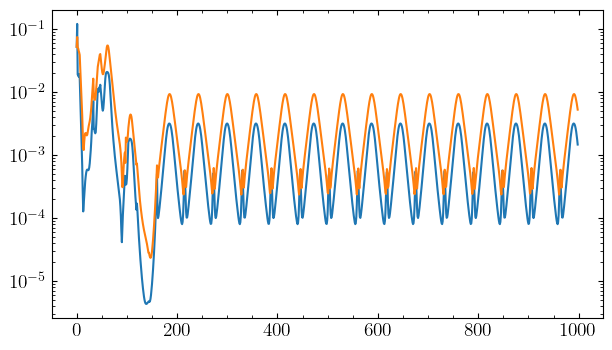

In [ ]:
# import matplotlib.pyplot as plt
# pred_norm = jax.vmap(lambda m: jnp.linalg.norm(m))(b_preds - bs[1:])
# prev_norm = jax.vmap(lambda m: jnp.linalg.norm(m))(bs[:-1] - bs[1:])
# plt.plot(pred_norm)
# plt.plot(prev_norm)
# plt.yscale("log")

In [6]:
ratios[:5]

Array([4.        , 2.00851098, 0.99855021, 1.01256814, 1.02232472],      dtype=float64)

In [7]:
jnp.linalg.norm(b_preds[1] - bs[2])

Array(0.11976103, dtype=float64)